## Destination Earth - ERA5 hourly data on single levels from 1940 to present - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Documentation ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels)


## Obtain Authentication Token (will be simplified in future)

In [19]:
import requests
from lxml import html
from urllib.parse import parse_qs, urlparse

IAM_URL = "https://auth.destine.eu/"
CLIENT_ID = "dedl-hda"
REALM = "desp"
SERVICE_URL = "https://hda.data.destination-earth.eu/stac/"


class DESPAuth:
    def __init__(self, username, password):
        self.username = username
        self.password = password

    def get_token(self):
        with requests.Session() as s:

            # Get the auth url
            auth_url = html.fromstring(s.get(url=IAM_URL + "/realms/" + REALM + "/protocol/openid-connect/auth",
                                     params = {
                                            "client_id": CLIENT_ID,
                                            "redirect_uri": SERVICE_URL,
                                            "scope": "openid",
                                            "response_type": "code"
                                     }
                                       ).content.decode()).forms[0].action
            
            # Login and get auth code
            login = s.post(auth_url,
                            data = {
                                "username" : self.username,
                                "password" : self.password,
                            },
                            allow_redirects=False
            )


            # We expect a 302, a 200 means we got sent back to the login page and there's probably an error message
            if login.status_code == 200:
                tree = html.fromstring(login.content)
                error_message_element = tree.xpath('//span[@id="input-error"]/text()')
                error_message = error_message_element[0].strip() if error_message_element else 'Error message not found'
                raise Exception(error_message)

            if login.status_code != 302:
                raise Exception("Login failed")
            

            auth_code = parse_qs(urlparse(login.headers["Location"]).query)['code'][0]

            # Use the auth code to get the token
            response = requests.post(IAM_URL + "/realms/" + REALM + "/protocol/openid-connect/token",
                    data = {
                        "client_id" : CLIENT_ID,
                        "redirect_uri" : SERVICE_URL,
                        "code" : auth_code,
                        "grant_type" : "authorization_code",
                        "scope" : ""
                    }
                )
            
            if response.status_code != 200:
                raise Exception("Failed to get token")
            
            token = response.json()['access_token']

            return token


class DEDLAuth:
    def __init__(self, desp_access_token):
        self.desp_access_token = desp_access_token

    def get_token(self):
        DEDL_TOKEN_URL='https://identity.data.destination-earth.eu/auth/realms/dedl/protocol/openid-connect/token'
        DEDL_CLIENT_ID='hda-public'
        AUDIENCE='hda-public'
        
        data = { 
            "grant_type": "urn:ietf:params:oauth:grant-type:token-exchange", 
            "subject_token": self.desp_access_token,
            "subject_issuer": "desp-oidc",
            "subject_token_type": "urn:ietf:params:oauth:token-type:access_token",
            "client_id": DEDL_CLIENT_ID,
            "audience": AUDIENCE
        }

        response = requests.post(DEDL_TOKEN_URL, data=data)
        
        print("Response code:", response.status_code)

        if response.status_code == 200: 
            dedl_token = response.json()["access_token"]
            return dedl_token
        else: 
            print(response.json())
            print("Error obtaining DEDL access token")
            

class AuthHandler:
    def __init__(self, username, password):
        self.username = username
        self.password = password
        self.desp_access_token = None
        self.dedl_access_token = None
    
    def get_token(self):
        # Get DESP auth token
        desp_auth = DESPAuth(self.username, self.password)
        self.desp_access_token = desp_auth.get_token()
        
        # Get DEDL auth token
        dedl_auth = DEDLAuth(self.desp_access_token)
        self.dedl_access_token = dedl_auth.get_token()
        
        return self.dedl_access_token

### Query using the DEDL HDA API


First, we get an access token for the API

In [20]:
import requests
import json
import os
from getpass import getpass

# Config file with password exits ?
file_path = 'myConfig.json'
if os.path.exists(file_path):
    print("Config File exists!")
    with open('myConfig.json') as f:
        config = json.load(f)
        DESP_USERNAME = config['username']
        DESP_PASSWORD = config['password']
else:
    DESP_USERNAME = input("Please input your DESP username: ")
    DESP_PASSWORD = getpass("Please input your DESP password: ")
    # Ask for confirmation before creating the file
    confirm = input("Do you want to create the config file? (yes/no): ")
    if confirm.lower() == 'yes':
        config['username'] = DESP_USERNAME
        config['password'] = DESP_PASSWORD
        with open(file_path, 'w') as f:
            json.dump(config, f)

auth = AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()

auth_headers = {"Authorization": f"Bearer {access_token}"}

Config File exists!
Response code: 200


## Filter
We have to setup up a filter and define which data to obtain.

[Filter Options HDA](https://hda.dedl.csgroup.space/stac/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/queryables?provider=copernicus_climate_data_store)

In [21]:
datechoice = "2020-06-10T10:00:00Z"
filters = {
    key: {"eq": value}
    for key, value in {
        "format": "grib",
        "variable": "2m_temperature",
        "time": "10:00"
    }.items()
}

In [22]:
## Make Data Request

In [24]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
 "collections": ["EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS"],
    "datetime": datechoice,
    "query": filters
})

# Requests to EO.ECMWF.DAT.DT_CLIMATE always return a single item containing all the requested data
print(response.json())
product = response.json()["features"][0]
product

{'type': 'FeatureCollection', 'stac_version': '1.0.0', 'stac_extensions': [], 'links': [{'rel': 'self', 'title': 'items', 'href': 'https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/items'}, {'rel': 'root', 'href': 'https://hda.data.destination-earth.eu/stac/'}, {'rel': 'parent', 'title': 'EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS', 'href': 'https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS'}], 'timeStamp': '2024-04-23T13:45:18.521457Z', 'numberMatched': 1, 'numberReturned': 1, 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'stac_extensions': ['https://stac-extensions.github.io/sar/v1.0.0/schema.json'], 'bbox': [-180.0, -90.0, 180.0, 90.0], 'collection': 'EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS', 'links': [{'rel': 'self', 'title': 'ERA5_SL_20200610_20200610_3b7d47f6f7e132fd54b1d8acbe418f63a22b45ff', 'href': 'https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.RE

{'type': 'Feature',
 'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/sar/v1.0.0/schema.json'],
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'collection': 'EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS',
 'links': [{'rel': 'self',
   'title': 'ERA5_SL_20200610_20200610_3b7d47f6f7e132fd54b1d8acbe418f63a22b45ff',
   'href': 'https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/items/ERA5_SL_20200610_20200610_3b7d47f6f7e132fd54b1d8acbe418f63a22b45ff?provider=copernicus_climate_data_store&_dc_qs=%257B%2522date%2522%253A%252B%25222020-06-10%2F2020-06-10%2522%252C%252B%2522format%2522%253A%252B%2522grib%2522%252C%252B%2522product_type%2522%253A%252B%2522reanalysis%2522%252C%252B%2522time%2522%253A%252B%252210%253A00%2522%252C%252B%2522variable%2522%253A%252B%25222m_temperature%2522%257D'},
  {'rel': 'root', 'href': 'https://hda.data.destination-earth.eu/stac/'},
  {'rel': 'parent',
   'title': 'EO.ECMWF.DAT.REANALYSIS_ERA5_

## Submission worked ? Once our product found, we download the data.

In [30]:
from IPython.display import JSON


# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
HTTP_SUCCESS_CODE = 200

response = requests.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    url = product['assets']['downloadLink']['href']
    print(url)
else:
    url = ""
    JSON(response.json(), expanded=True)

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/items/ERA5_SL_20200610_20200610_3b7d47f6f7e132fd54b1d8acbe418f63a22b45ff/download?provider=copernicus_climate_data_store&_dc_qs=%257B%2522date%2522%253A%252B%25222020-06-10%2F2020-06-10%2522%252C%252B%2522format%2522%253A%252B%2522grib%2522%252C%252B%2522product_type%2522%253A%252B%2522reanalysis%2522%252C%252B%2522time%2522%253A%252B%252210%253A00%2522%252C%252B%2522variable%2522%253A%252B%25222m_temperature%2522%257D


## Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

In [33]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if response.headers.get("Location") == "None":
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)
        response.raise_for_status()
else:
    response = requests.get(url,stream=True,headers=auth_headers)

filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading adaptor.mars.internal-1713601880.2958605-26327-14-f5eb9261-1b2f-4147-9527-e33b21637b2e.grib


100%|██████████| 2.08M/2.08M [00:00<00:00, 9.55MB/s]


## EarthKit

Lets plot the result file
[EarthKit Documentation] https://earthkit-data.readthedocs.io/en/latest/index.html

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [34]:
!pip install --quiet earthkit-data
!pip install --quiet earthkit-maps --upgrade
!pip install --quiet earthkit-regrid #(Optional for spectral variables)
!pip install --quiet cf-units #(Optional for unit conversion in maps)

In [35]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

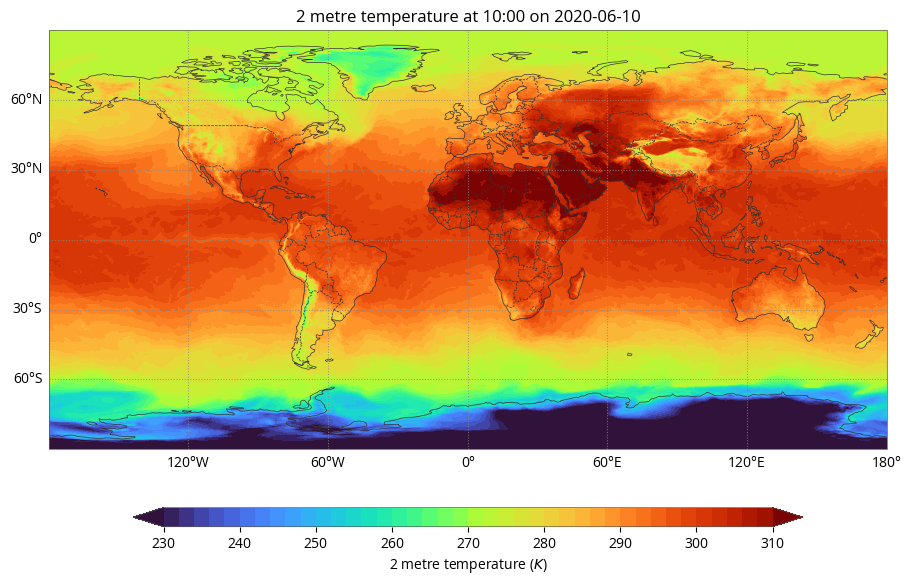

In [36]:
data = earthkit.data.from_source("file", filename)
data.ls
earthkit.maps.quickplot(data,#style=style
                       )